In [5]:
import pandas as pd
from collections import deque

# File paths
csv_file_path = r"D:\Bristol\Skills in mathematical research\week15-\synthetic_company_structures_500_links.csv"
output_path = r"D:\Bristol\Skills in mathematical research\week15-\shareholder_companies_table.csv"

# Read CSV
print("Reading data...")
df = pd.read_csv(csv_file_path)

# Ensure correct data types
df['company_id'] = df['company_id'].astype(int)
df['shareholder_id'] = df['shareholder_id'].astype(int)
df['shareholder_percent'] = df['shareholder_percent'].astype(float)

# Build ownership graph: company → list of (shareholder, percent)
ownership_graph = {}
for _, row in df.iterrows():
    company_id = row['company_id']
    shareholder_id = row['shareholder_id']
    ownership_percent = row['shareholder_percent']
    
    if company_id not in ownership_graph:
        ownership_graph[company_id] = []
    
    ownership_graph[company_id].append((shareholder_id, ownership_percent))

# Collect all unique company and shareholder IDs
all_company_ids = set(df['company_id'])
all_shareholder_ids = set(df['shareholder_id'])

# Identify individual shareholders (those who are not companies)
individual_shareholders = [id for id in all_shareholder_ids if id not in all_company_ids]

# BFS function to find the ultimate owner
def find_ultimate_owner(company_id):
    if company_id not in ownership_graph:
        return {
            'ultimate_owner': None,
            'path': [],
            'path_labels': [],
            'path_length': 0,
            'effective_ownership': 0,
            'cycle_detected': 'no'
        }
    
    visited = set()
    queue = deque()
    
    # Start from this company
    queue.append({
        'id': company_id,
        'path': [company_id],
        'path_labels': [],
        'path_length': 0,
        'ownership_percentages': []
    })
    visited.add(company_id)
    
    # BFS loop
    while queue:
        current = queue.popleft()
        current_id = current['id']
        current_path = current['path']
        current_path_labels = current['path_labels']
        current_links = current['path_length']
        current_percentages = current['ownership_percentages']
        
        shareholders = ownership_graph.get(current_id, [])
        
        for shareholder_id, percent in shareholders:
            if percent >= 50:
                cycle_detected = 'no'
                if shareholder_id in current_path:
                    cycle_detected = 'yes'
                    
                new_path = current_path + [shareholder_id]
                new_path_labels = current_path_labels + [f"{percent:.2f}%"]
                new_links = current_links + 1
                new_percentages = current_percentages + [percent]
                
                if shareholder_id in individual_shareholders:
                    # Calculate effective ownership
                    effective_ownership = 100
                    if new_percentages:
                        effective_ownership = new_percentages[0]
                        for p in new_percentages[1:]:
                            effective_ownership = effective_ownership * p / 100
                    
                    return {
                        'ultimate_owner': shareholder_id,
                        'path': new_path,
                        'path_labels': new_path_labels,
                        'path_length': new_links,
                        'effective_ownership': effective_ownership,
                        'cycle_detected': cycle_detected
                    }
                
                if shareholder_id not in visited and cycle_detected == 'no':
                    queue.append({
                        'id': shareholder_id,
                        'path': new_path,
                        'path_labels': new_path_labels,
                        'path_length': new_links,
                        'ownership_percentages': new_percentages
                    })
                    visited.add(shareholder_id)
    
    # If no ultimate owner is found
    return {
        'ultimate_owner': None,
        'path': [],
        'path_labels': [],
        'path_length': 0,
        'effective_ownership': 0,
        'cycle_detected': 'no'
    }

print("Finding ultimate owners using BFS...")

results = []
total_companies = len(all_company_ids)
completed = 0

for company_id in all_company_ids:
    result = find_ultimate_owner(company_id)
    
    completed += 1
    if completed % 50 == 0 or completed == total_companies:
        print(f"Processed {completed}/{total_companies} companies...")
    
    if result['ultimate_owner']:
        results.append({
            'shareholder_id': result['ultimate_owner'],
            'controlled_company_id': company_id,
            'ownership_percent': result['effective_ownership'],
            'cycle_detected': result['cycle_detected']
        })

results_df = pd.DataFrame(results)

# Count how many companies each shareholder controls
shareholder_counts = results_df['shareholder_id'].value_counts().reset_index()
shareholder_counts.columns = ['shareholder_id', 'number_of_companies_controlled']

# Merge counts into final table
final_df = pd.merge(results_df, shareholder_counts, on='shareholder_id', how='left')

# Sort by shareholder, then count, then company ID
final_df = final_df.sort_values(
    ['shareholder_id', 'number_of_companies_controlled', 'controlled_company_id'],
    ascending=[True, False, True]
)

# Format ownership percent as string with two decimal places
final_df['ownership_percent'] = final_df['ownership_percent'].apply(lambda x: f"{x:.2f}%")

# Reorder columns
final_df = final_df[
    ['shareholder_id', 'number_of_companies_controlled', 'controlled_company_id',
     'ownership_percent', 'cycle_detected']
]

# Commented out: Do not save CSV
# final_df.to_csv(output_path, index=False)
# print(f"CSV successfully saved to: {output_path}")

# Print preview
print("\nPreview of first 10 rows:")
print(final_df.head(10))


Reading data...
Finding ultimate owners using BFS...
Processed 50/390 companies...
Processed 100/390 companies...
Processed 150/390 companies...
Processed 200/390 companies...
Processed 250/390 companies...
Processed 300/390 companies...
Processed 350/390 companies...
Processed 390/390 companies...

Preview of first 10 rows:
     shareholder_id  number_of_companies_controlled  controlled_company_id  \
228             7.0                               1                    581   
283             8.0                               1                    725   
52              9.0                               1                    133   
39             21.0                               1                    102   
255            25.0                               1                    648   
333            42.0                               1                    846   
150            50.0                               2                    399   
168            50.0                              

Reading data...
Data sample:
   company_id  shareholder_id  shareholder_percent
0         684             881             1.000000
1         473             365           100.000000
2         883             376            16.218391
3         218              61           100.000000
4         184             510            62.000000
Total number of companies: 390
Total number of shareholders: 384
Number of individual shareholders: 228

Sample of ownership relationships:
Company 684.0 has shareholders:
  - Shareholder 881.0 owns 1.0% of Company 684.0
  - Shareholder 506.0 owns 99.0% of Company 684.0
Company 473.0 has shareholders:
  - Shareholder 365.0 owns 100.0% of Company 473.0
Company 883.0 has shareholders:
  - Shareholder 376.0 owns 16.2183908% of Company 883.0
  - Shareholder 220.0 owns 66.0% of Company 883.0
  - Shareholder 696.0 owns 17.7816092% of Company 883.0
Company 218.0 has shareholders:
  - Shareholder 61.0 owns 100.0% of Company 218.0
Company 184.0 has shareholders:
  -

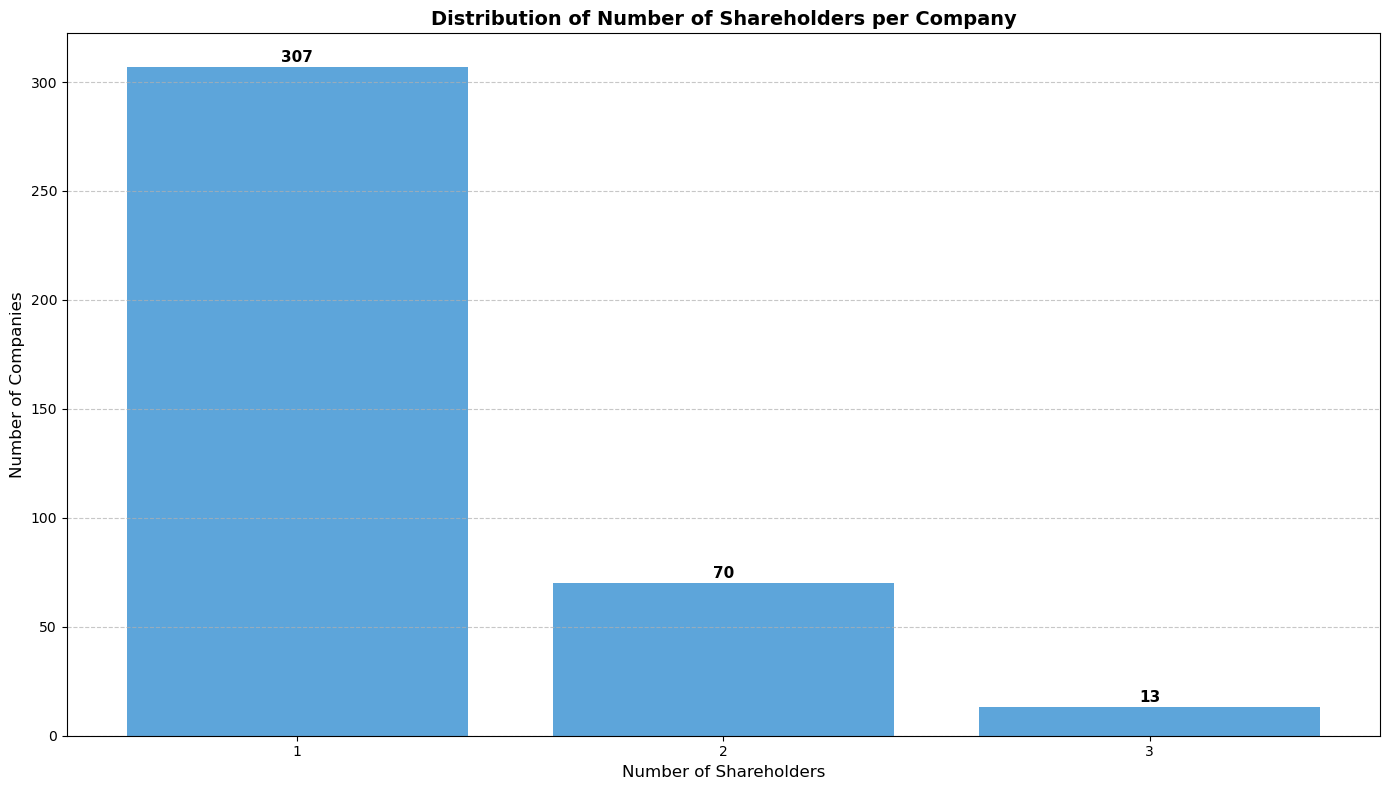


Distribution of Ultimate Owners:
-------------------------------
102 ultimate owners each own 1 companies
53 ultimate owners each own 2 companies
14 ultimate owners each own 3 companies
10 ultimate owners each own 4 companies
5 ultimate owners each own 5 companies
2 ultimate owners each own 6 companies
1 ultimate owners each own 7 companies
1 ultimate owners each own 8 companies
1 ultimate owners each own 10 companies
1 ultimate owners each own 11 companies
1 ultimate owners each own 13 companies
1 ultimate owners each own 14 companies


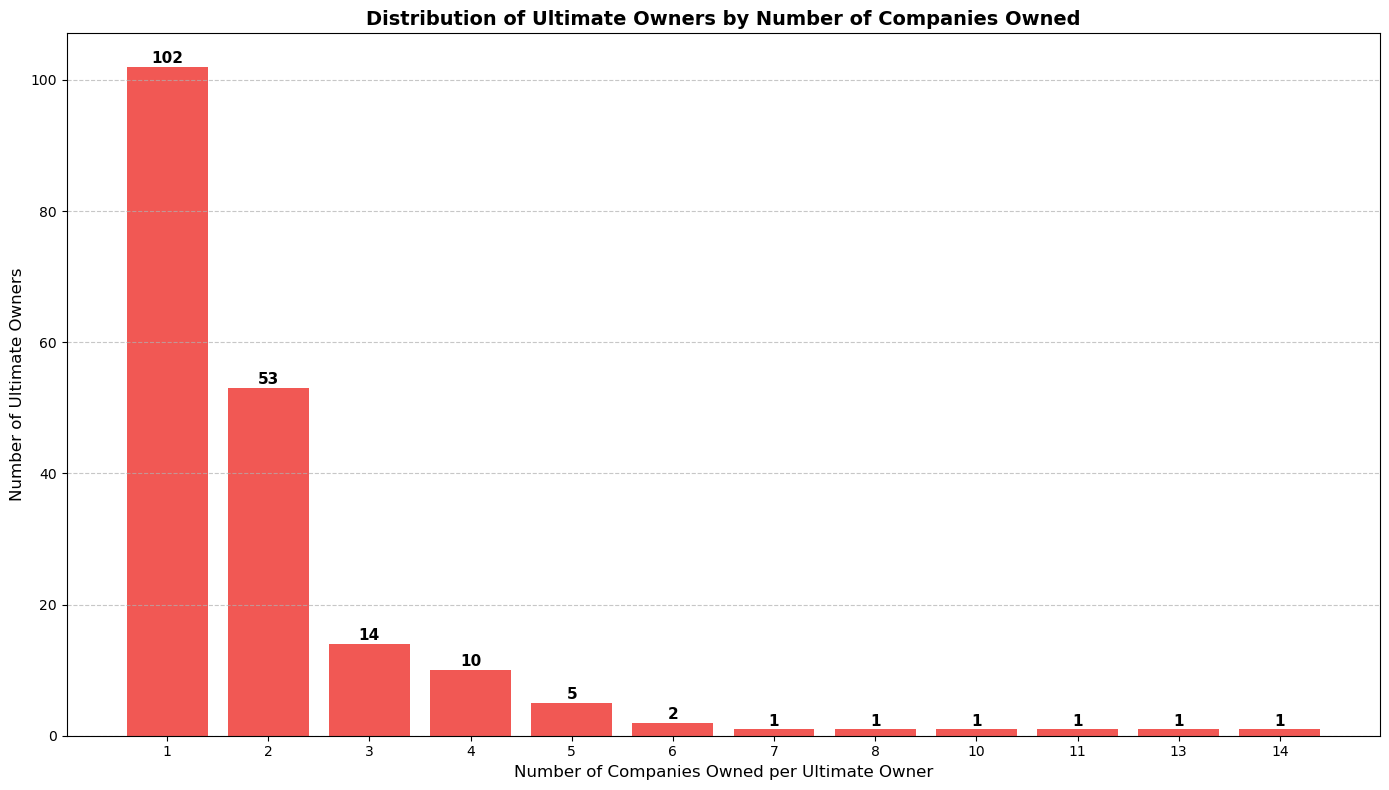


Top 10 Ultimate Owners:
----------------------
1. Shareholder 110.0 is the ultimate owner of 14 companies
2. Shareholder 324.0 is the ultimate owner of 13 companies
3. Shareholder 105.0 is the ultimate owner of 11 companies
4. Shareholder 966.0 is the ultimate owner of 10 companies
5. Shareholder 484.0 is the ultimate owner of 8 companies
6. Shareholder 544.0 is the ultimate owner of 7 companies
7. Shareholder 793.0 is the ultimate owner of 6 companies
8. Shareholder 666.0 is the ultimate owner of 6 companies
9. Shareholder 232.0 is the ultimate owner of 5 companies
10. Shareholder 644.0 is the ultimate owner of 5 companies


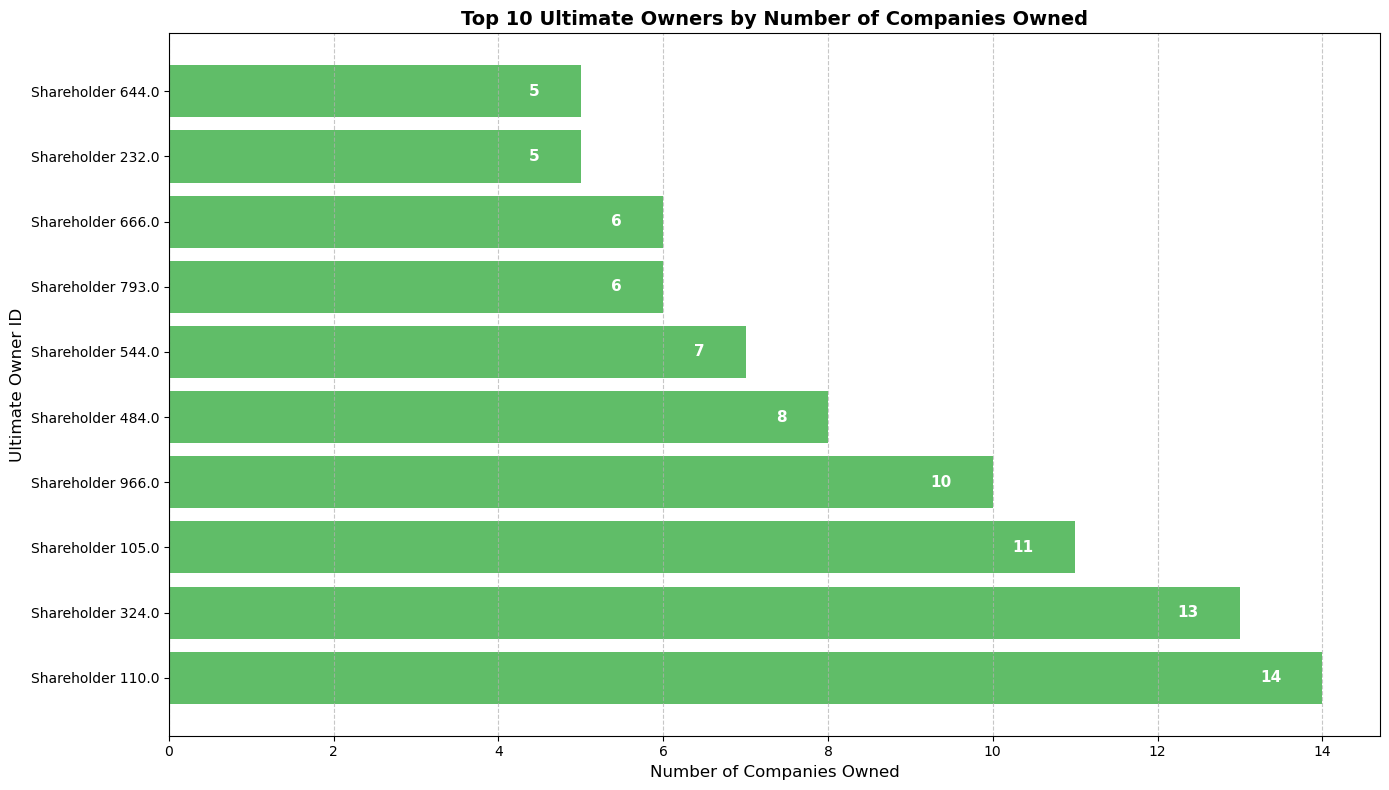


Total number of unique ultimate owners: 192
Total number of ownership relationships: 390

Distribution of Ultimate Owners by Ownership Percentage:
------------------------------------------------------
100%: 153 ultimate owners
90-99%: 20 ultimate owners
80-89%: 12 ultimate owners
70-79%: 20 ultimate owners
60-69%: 14 ultimate owners
50-59%: 17 ultimate owners
< 50%: 5 ultimate owners
Sum across all ranges: 241
Total unique ultimate owners: 192
Number of ultimate owners appearing in multiple ranges: 35

=== Ultimate Owners Classified by Maximum Ownership Percentage ===
100%: 153 ultimate owners
90-99%: 9 ultimate owners
80-89%: 8 ultimate owners
70-79%: 9 ultimate owners
60-69%: 5 ultimate owners
50-59%: 8 ultimate owners
< 50%: 0 ultimate owners
Sum across all ranges: 192
Total unique ultimate owners: 192
✓ The sum matches the total number of unique ultimate owners

Comparison of Both Distributions:
  Ownership Percent Range  All Ownership Percentages  \
0                    100%    

<Figure size 1400x800 with 0 Axes>

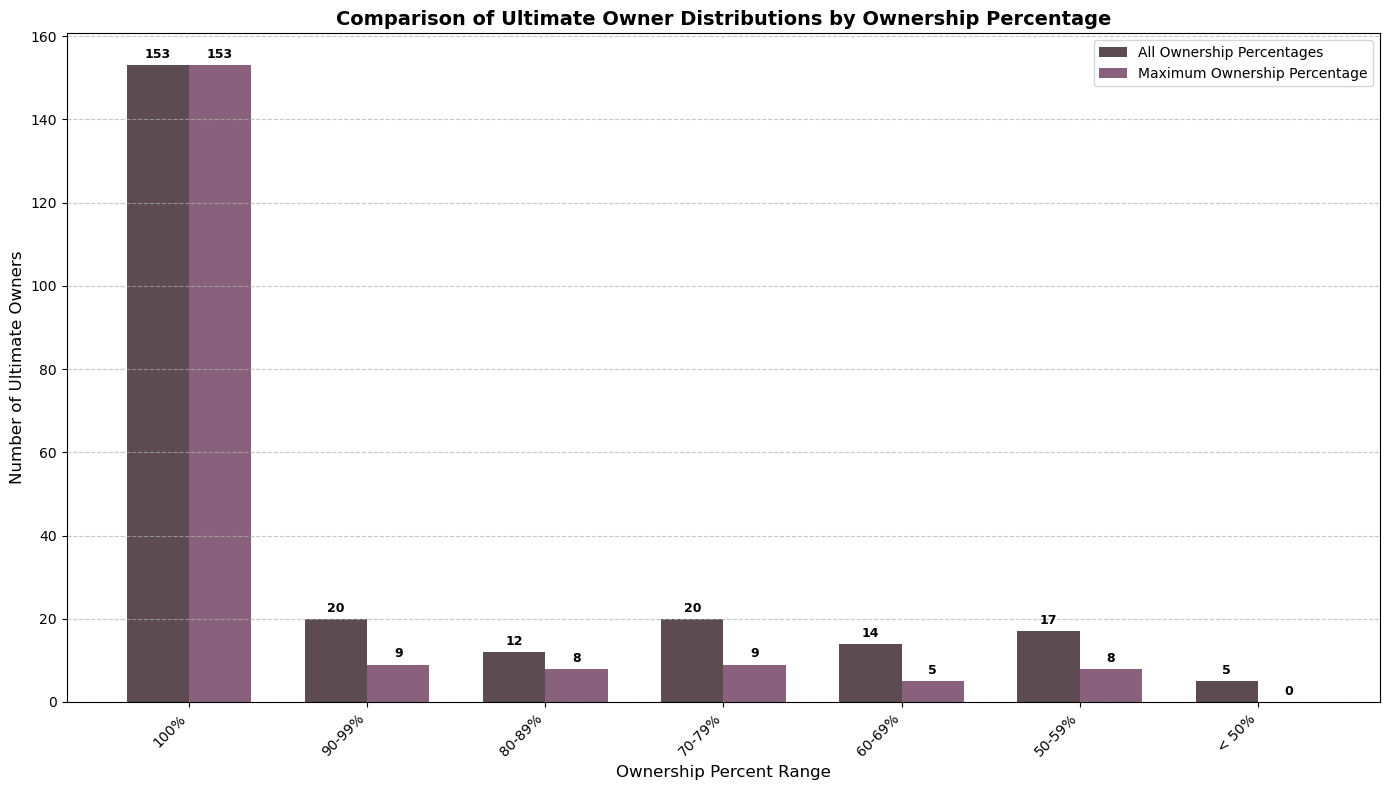

In [13]:
import pandas as pd
from collections import deque, Counter
import matplotlib.pyplot as plt
import json
import numpy as np

# File path - update this to your specific path
csv_file_path = r"D:\Bristol\Skills in mathematical research\week15-\synthetic_company_structures_500_links.csv"

# Read the CSV file
print("Reading data...")
df = pd.read_csv(csv_file_path)

# Display first few rows to verify data
print("Data sample:")
print(df.head())

# Ensure all values are properly typed
df['company_id'] = df['company_id'].astype(int)
df['shareholder_id'] = df['shareholder_id'].astype(int)
df['shareholder_percent'] = df['shareholder_percent'].astype(float)

# Create a graph where companies are nodes, and edges represent shareholding relationships
ownership_graph = {}
for _, row in df.iterrows():
    company_id = row['company_id']
    shareholder_id = row['shareholder_id']
    ownership_percent = row['shareholder_percent']
    
    if company_id not in ownership_graph:
        ownership_graph[company_id] = []
    
    ownership_graph[company_id].append((shareholder_id, ownership_percent))

# Get all unique company IDs and shareholder IDs
all_company_ids = set(df['company_id'])
all_shareholder_ids = set(df['shareholder_id'])

# Identify potential individual shareholders (those that don't appear as companies)
individual_shareholders = [id for id in all_shareholder_ids if id not in all_company_ids]

print(f"Total number of companies: {len(all_company_ids)}")
print(f"Total number of shareholders: {len(all_shareholder_ids)}")
print(f"Number of individual shareholders: {len(individual_shareholders)}")

# Print a sample of the ownership graph to verify it's constructed correctly
print("\nSample of ownership relationships:")
count = 0
for company, shareholders in ownership_graph.items():
    if count < 5:
        print(f"Company {company} has shareholders:")
        for shareholder_id, percent in shareholders:
            print(f"  - Shareholder {shareholder_id} owns {percent}% of Company {company}")
        count += 1
    else:
        break

# BFS function to find the ultimate owner
def find_ultimate_owner(company_id):
    if company_id not in ownership_graph:
        return {
            'ultimate_owner': None,
            'is_individual': False,
            'path': [],
            'path_labels': [],
            'path_length': 0,
            'effective_ownership': 0,
            'num_shareholders': 0
        }
    
    # Initialize BFS variables
    visited = set()
    queue = deque()
    
    # Count shareholders for this company
    num_shareholders = len(ownership_graph.get(company_id, []))
    
    # Initialize with starting company
    queue.append({
        'id': company_id,
        'path': [company_id],
        'path_labels': [],
        'path_length': 0,
        'ownership_percentages': [],
        'num_shareholders': num_shareholders
    })
    visited.add(company_id)
    
    # BFS main loop - continue until queue is empty
    while queue:
        # Get the next node from the front of the queue (FIFO)
        current = queue.popleft()
        current_id = current['id']
        current_path = current['path']
        current_path_labels = current['path_labels']
        current_links = current['path_length']
        current_percentages = current['ownership_percentages']
        current_num_shareholders = current['num_shareholders']
        
        # Look for shareholders of this company
        shareholders = ownership_graph.get(current_id, [])
        
        # Check each shareholder
        for shareholder_id, percent in shareholders:
            # Only consider majority shareholders (≥50%)
            if percent >= 50:
                # Create new path and path labels
                new_path = current_path + [shareholder_id]
                new_path_labels = current_path_labels + [f"{percent:.2f}%"]
                new_links = current_links + 1
                new_percentages = current_percentages + [percent]
                
                # If this is an individual shareholder, we've found an ultimate owner
                if shareholder_id in individual_shareholders:
                    # Calculate the effective ownership percentage
                    effective_ownership = 100
                    if new_percentages:
                        effective_ownership = new_percentages[0]  # Start with first percentage
                        for p in new_percentages[1:]:
                            effective_ownership = effective_ownership * p / 100
                    
                    return {
                        'ultimate_owner': shareholder_id,
                        'is_individual': True,
                        'path': new_path,
                        'path_labels': new_path_labels,
                        'path_length': new_links,
                        'effective_ownership': effective_ownership,
                        'num_shareholders': current_num_shareholders
                    }
                
                # If it's a company shareholder and not yet visited
                if shareholder_id not in visited:
                    # Count shareholders for this new company
                    new_num_shareholders = len(ownership_graph.get(shareholder_id, []))
                    
                    # Add this company to the queue for processing
                    queue.append({
                        'id': shareholder_id,
                        'path': new_path,
                        'path_labels': new_path_labels,
                        'path_length': new_links,
                        'ownership_percentages': new_percentages,
                        'num_shareholders': new_num_shareholders
                    })
                    visited.add(shareholder_id)
    
    # If no ultimate owner is found
    return {
        'ultimate_owner': None,
        'is_individual': False,
        'path': [],
        'path_labels': [],
        'path_length': 0,
        'effective_ownership': 0,
        'num_shareholders': num_shareholders
    }

print("Finding ultimate owners using BFS...")

# Find the ultimate owner for each company
ultimate_owners_map = {}
companies_without_ultimate_owner = []

# Track progress
total_companies = len(all_company_ids)
completed = 0

for company_id in all_company_ids:
    result = find_ultimate_owner(company_id)
    
    completed += 1
    if completed % 50 == 0 or completed == total_companies:
        print(f"Processed {completed}/{total_companies} companies...")
    
    if result['ultimate_owner']:
        ultimate_owners_map[company_id] = result
    else:
        companies_without_ultimate_owner.append(company_id)

print(f"Number of companies with ultimate owners: {len(ultimate_owners_map)}")
print(f"Number of companies without ultimate owners: {len(companies_without_ultimate_owner)}")

# Display results if we found any ultimate owners
if len(ultimate_owners_map) > 0:
    # Show examples of ultimate ownership
    print("\nExamples of Ultimate Ownership:")
    print("-------------------------------")
    
    count = 0
    for company_id, result in sorted(ultimate_owners_map.items()):
        if count < 10:
            # Format the path with ownership percentages
            path_with_labels = []
            for i in range(len(result['path']) - 1):
                path_with_labels.append(str(result['path'][i]))
                if i < len(result['path_labels']):
                    path_with_labels.append(result['path_labels'][i])
            
            path_with_labels.append(str(result['path'][-1]))
            
            print(f"Company {company_id}: Ultimate owner is Shareholder {result['ultimate_owner']}")
            print(f"   Ownership path: {' -> '.join(path_with_labels)}")
            print(f"   Path length: {result['path_length']}")
            print(f"   Number of shareholders: {result['num_shareholders']}")
            print(f"   Effective ownership percent: {result['effective_ownership']:.2f}%")
            print("")
            count += 1
    
    
    # ----------------------------------------------------
    company_shareholder_counts = {}
    for result in ultimate_owners_map.values():
        count = result['num_shareholders']
        if count not in company_shareholder_counts:
            company_shareholder_counts[count] = 0
        company_shareholder_counts[count] += 1
    
    print("Distribution of Companies by Number of Shareholders:")
    print("--------------------------------------------------")
    
    for count, num_companies in sorted(company_shareholder_counts.items()):
        print(f"Companies with {count} shareholders: {num_companies}")
    
    # Visualize company shareholder count distribution
    plt.figure(figsize=(14, 8))
    shareholder_counts = list(sorted(company_shareholder_counts.keys()))
    company_counts = [company_shareholder_counts[count] for count in shareholder_counts]
    
    bars = plt.bar(shareholder_counts, company_counts, color='#5DA5DA')
    plt.xlabel('Number of Shareholders', fontsize=12)
    plt.ylabel('Number of Companies', fontsize=12)
    plt.title('Distribution of Number of Shareholders per Company', fontsize=14, fontweight='bold')
    plt.xticks(shareholder_counts, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only show labels for non-zero values
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                     f'{int(height)}',
                     ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('company_shareholder_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
#-----------------------------------------------------
    # Find most common ultimate owners
    ultimate_owner_counts = {}
    ultimate_owner_companies = {}  # Track companies owned by each ultimate owner
    
    for company_id, result in ultimate_owners_map.items():
        owner_id = result['ultimate_owner']
        if owner_id not in ultimate_owner_counts:
            ultimate_owner_counts[owner_id] = 0
            ultimate_owner_companies[owner_id] = []
        
        ultimate_owner_counts[owner_id] += 1
        ultimate_owner_companies[owner_id].append((company_id, result['effective_ownership'], result['path_length']))
    
    # Distribution of Ultimate Owners (how many owners own how many companies)
    owner_company_counts = {}
    for count in ultimate_owner_counts.values():
        if count not in owner_company_counts:
            owner_company_counts[count] = 0
        owner_company_counts[count] += 1
    
    print("\nDistribution of Ultimate Owners:")
    print("-------------------------------")
    
    for company_count, owner_count in sorted(owner_company_counts.items()):
        print(f"{owner_count} ultimate owners each own {company_count} companies")
    
    # Visualize the distribution of ultimate owners
    plt.figure(figsize=(14, 8))
    company_counts = list(sorted(owner_company_counts.keys()))
    owner_counts = [owner_company_counts[count] for count in company_counts]
    
    # Create x-axis labels for the owner distribution
    x_labels = [f"{count}" for count in company_counts]
    
    bars = plt.bar(range(len(company_counts)), owner_counts, color='#F15854')
    plt.xlabel('Number of Companies Owned per Ultimate Owner', fontsize=12)
    plt.ylabel('Number of Ultimate Owners', fontsize=12)
    plt.title('Distribution of Ultimate Owners by Number of Companies Owned', fontsize=14, fontweight='bold')
    plt.xticks(range(len(company_counts)), x_labels, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('ultimate_owners_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
   
    # ----------------------------------------------------------------
    print("\nTop 10 Ultimate Owners:")
    print("----------------------")
    
    top_owners = sorted(ultimate_owner_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (owner_id, count) in enumerate(top_owners):
        print(f"{i+1}. Shareholder {owner_id} is the ultimate owner of {count} companies")
    
    # Visualize top owners with value labels
    plt.figure(figsize=(14, 8))
    top_owner_ids = [f"Shareholder {owner}" for owner, _ in top_owners]
    top_owner_counts = [count for _, count in top_owners]
    
    # Horizontal bar chart for top owners
    bars = plt.barh(top_owner_ids, top_owner_counts, color='#60BD68')
    plt.xlabel('Number of Companies Owned', fontsize=12)
    plt.ylabel('Ultimate Owner ID', fontsize=12)
    plt.title('Top 10 Ultimate Owners by Number of Companies Owned', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add value labels inside each bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width - 0.5, bar.get_y() + bar.get_height()/2,
                 f'{int(width)}',
                 ha='right', va='center', fontsize=11, fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.savefig('top_owners_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
   #----------------------------------------------------
    
    # Count the number of unique ultimate owners
    num_ultimate_owners = len(ultimate_owner_counts)
    print(f"\nTotal number of unique ultimate owners: {num_ultimate_owners}")
    
    # Count the total number of ownership relationships
    total_relationships = sum(ultimate_owner_counts.values())
    print(f"Total number of ownership relationships: {total_relationships}")
    
   
    # ----------------------------------------------------------------
    # Define the ownership percentage ranges
    ownership_ranges = {
        "100%": 0,
        "90-99%": 0,
        "80-89%": 0,
        "70-79%": 0,
        "60-69%": 0,
        "50-59%": 0,
        "< 50%": 0
    }
    
    # Track which owners fall into each category
    owners_in_ranges = {
        "100%": set(),
        "90-99%": set(),
        "80-89%": set(),
        "70-79%": set(),
        "60-69%": set(),
        "50-59%": set(),
        "< 50%": set()
    }
    
    # For each ultimate owner, find their ownership percentage range(s)
    for owner_id, companies in ultimate_owner_companies.items():
        for _, percent, _ in companies:
            if percent == 100:
                owners_in_ranges["100%"].add(owner_id)
            elif 90 <= percent < 100:
                owners_in_ranges["90-99%"].add(owner_id)
            elif 80 <= percent < 90:
                owners_in_ranges["80-89%"].add(owner_id)
            elif 70 <= percent < 80:
                owners_in_ranges["70-79%"].add(owner_id)
            elif 60 <= percent < 70:
                owners_in_ranges["60-69%"].add(owner_id)
            elif 50 <= percent < 60:
                owners_in_ranges["50-59%"].add(owner_id)
            else:
                owners_in_ranges["< 50%"].add(owner_id)
    
    # Count how many unique owners are in each range
    for range_name, owners in owners_in_ranges.items():
        ownership_ranges[range_name] = len(owners)
    
    # Order the ownership ranges
    ordered_ranges = ["100%", "90-99%", "80-89%", "70-79%", "60-69%", "50-59%", "< 50%"]
    ordered_values = [ownership_ranges[r] for r in ordered_ranges]
    
    print("\nDistribution of Ultimate Owners by Ownership Percentage:")
    print("------------------------------------------------------")
    
    for r, v in zip(ordered_ranges, ordered_values):
        print(f"{r}: {v} ultimate owners")
    
    sum_of_ranges = sum(ordered_values)
    print(f"Sum across all ranges: {sum_of_ranges}")
    print(f"Total unique ultimate owners: {num_ultimate_owners}")
    
    # Count multi-range owners
    multi_range_owners = 0
    for owner_id, companies in ultimate_owner_companies.items():
        # Count distinct percentage ranges this owner has
        owner_ranges = set()
        for _, percent, _ in companies:
            if percent == 100:
                owner_ranges.add("100%")
            elif 90 <= percent < 100:
                owner_ranges.add("90-99%")
            elif 80 <= percent < 90:
                owner_ranges.add("80-89%")
            elif 70 <= percent < 80:
                owner_ranges.add("70-79%")
            elif 60 <= percent < 70:
                owner_ranges.add("60-69%")
            elif 50 <= percent < 60:
                owner_ranges.add("50-59%")
            else:
                owner_ranges.add("< 50%")
        
        if len(owner_ranges) > 1:
            multi_range_owners += 1
    
    print(f"Number of ultimate owners appearing in multiple ranges: {multi_range_owners}")
    
    # ANALYSIS 7: ULTIMATE OWNERS BY MAXIMUM OWNERSHIP PERCENTAGE
    print("\n=== Ultimate Owners Classified by Maximum Ownership Percentage ===")
    
    # Define the ownership percentage ranges for maximum analysis
    max_ownership_ranges = {
        "100%": 0,
        "90-99%": 0,
        "80-89%": 0,
        "70-79%": 0,
        "60-69%": 0,
        "50-59%": 0,
        "< 50%": 0
    }
    
    # For each ultimate owner, find their maximum ownership percentage
    for owner_id, companies in ultimate_owner_companies.items():
        # Find the maximum ownership percentage for this owner
        max_percent = max(percent for _, percent, _ in companies)
        
        # Classify based on the maximum percentage
        if max_percent == 100:
            max_ownership_ranges["100%"] += 1
        elif 90 <= max_percent < 100:
            max_ownership_ranges["90-99%"] += 1
        elif 80 <= max_percent < 90:
            max_ownership_ranges["80-89%"] += 1
        elif 70 <= max_percent < 80:
            max_ownership_ranges["70-79%"] += 1
        elif 60 <= max_percent < 70:
            max_ownership_ranges["60-69%"] += 1
        elif 50 <= max_percent < 60:
            max_ownership_ranges["50-59%"] += 1
        else:
            max_ownership_ranges["< 50%"] += 1
    
    # Order the ownership ranges
    ordered_ranges = ["100%", "90-99%", "80-89%", "70-79%", "60-69%", "50-59%", "< 50%"]
    max_ordered_values = [max_ownership_ranges[r] for r in ordered_ranges]
    
    # Display the distribution
    for r, v in zip(ordered_ranges, max_ordered_values):
        print(f"{r}: {v} ultimate owners")
    
    # Verify the sum matches the total number of ultimate owners
    sum_of_max_ranges = sum(max_ordered_values)
    print(f"Sum across all ranges: {sum_of_max_ranges}")
    print(f"Total unique ultimate owners: {num_ultimate_owners}")
    if sum_of_max_ranges == num_ultimate_owners:
        print("✓ The sum matches the total number of unique ultimate owners")
    else:
        print("! The sum does not match the total number of unique ultimate owners")
    
    # Compare the two distributions side by side
    compare_data = pd.DataFrame({
        'Ownership Percent Range': ordered_ranges,
        'All Ownership Percentages': ordered_values,
        'Maximum Ownership Percentage': max_ordered_values
    })
    
    print("\nComparison of Both Distributions:")
    print(compare_data)
    
    # Create a side-by-side bar chart comparing both distributions
    plt.figure(figsize=(14, 8))
    
    x = np.arange(len(ordered_ranges))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, ordered_values, width, label='All Ownership Percentages', color='#5C4B51')
    rects2 = ax.bar(x + width/2, max_ordered_values, width, label='Maximum Ownership Percentage', color='#8A617C')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Ownership Percent Range', fontsize=12)
    ax.set_ylabel('Number of Ultimate Owners', fontsize=12)
    ax.set_title('Comparison of Ultimate Owner Distributions by Ownership Percentage', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_ranges, rotation=45, ha='right')
    ax.legend()
    
    # Add value labels on top of each bar
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    add_labels(rects1)
    add_labels(rects2)
    
    fig.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('ultimate_owner_ownership_comparison.png', dpi=300, bbox_inches='tight')
    plt